# Heterokaryon Similarity Analysis

Simple analysis which sees how close the different single cells are to MRC5/3hr/16hr/48hr samples from the heterokaryon reprogramming system. The code is similar to (borrowed from) 20200210_scProgress.

In [13]:
library(ggrepel)
library(reshape2)
require(stringr)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)
library(Matrix)
library(patchwork)

Loading required package: ggplot2

Loading required package: stringr

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Load

## Load Data

In [14]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [15]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [16]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 409052      4

chr  bp1   bp2   site_name       
chr1_10355_10867 chr1 10355 10867 chr1_10355_10867
chr1_41995_42521 chr1 41995 42521 chr1_41995_42521
chr1_46067_46593 chr1 46067 46593 chr1_46067_46593
chr1_48475_48975 chr1 48475 48975 chr1_48475_48975
chr1_51286_52235 chr1 51286 52235 chr1_51286_52235
chr1_58648_59148 chr1 58648 59148 chr1_58648_59148

In [17]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [18]:
pmatRowSums = Matrix::rowSums(pmat)

## Soft Single-cell Similarity
Consider reads in all bins in heterokaryons and find similarity with raw peak counts. E.g. dot product between vector of normalized counts in 3hr - vector of normalized counts in CC. The difference vector is scaled by sgn(x).(1+|x|) and dot product is normalized by sequencing depth.

In [298]:
# het_cts <- read.table("./data/20200518_n76052/het.nodox.counts.overlap.no_iPSC.merged.500.tsv", header=T)
het_cts <- read.table("./data/20200518_n76052/het.nodox.counts.overlap.no_iPSC.merge.500.tsv", header=T)
rownames(het_cts)=paste(het_cts$chrom,het_cts$start,het_cts$end,sep='_')
het_cts$chrom = NULL
het_cts$start = NULL
het_cts$end = NULL
head(het_cts)
dim(het_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10355_10867 0                      0                   
chr1_41995_42521 0                      0                   
chr1_46067_46593 2                      0                   
chr1_48475_48975 0                      0                   
chr1_51286_52235 2                      0                   
chr1_58648_59148 0                      0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10355_10867 0                     0                     
chr1_41995_42521 0                     0                     
chr1_46067_46593 0                     0                     
chr1_48475_48975 0                     0                     
chr1_51286_52235 2                     0                     
chr1_58648_59148 0                     0                     
                 het.48hr.nodox.overlap
chr1_10355_10867 2                     
chr1_41995_42521 0                     
chr1_46067_46593 0                     
chr1_48475_48975 0                     
chr1_51286_52235 2                     
chr1_58648_59148 0

[1] 409220      5

In [299]:
dim(regions)
sum(rownames(regions) %in% rownames(het_cts))

[1] 409052      4

[1] 409052

In [300]:
# rearrange to same order as regions
het_cts = het_cts[rownames(regions), ]

In [301]:
sum(rowSums(het_cts<40)==0)

[1] 63046

In [302]:
het_norm_cts = t(t(het_cts)/estimateSizeFactorsForMatrix(het_cts[rowSums(het_cts<40)==0,]))
head(het_norm_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10355_10867 0.0000000              0                   
chr1_41995_42521 0.0000000              0                   
chr1_46067_46593 0.8075969              0                   
chr1_48475_48975 0.0000000              0                   
chr1_51286_52235 0.8075969              0                   
chr1_58648_59148 0.0000000              0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10355_10867 0.000000              0                     
chr1_41995_42521 0.000000              0                     
chr1_46067_46593 0.000000              0                     
chr1_48475_48975 0.000000              0                     
chr1_51286_52235 2.273745              0                     
chr1_58648_59148 0.000000              0                     
                 het.48hr.nodox.overlap
chr1_10355_10867 2.321718              
chr1_41995_42521 0.000000              
chr1_46067_46593 0.000000              
chr1_48475_48975 0.000000              
chr1_51286_52235 2.321718              
chr1_58648_59148 0.000000

In [303]:
regions_gr = GRanges(sub("_", "-", sub("_", ":",rownames(het_norm_cts))))

In [304]:
# normalize by bin size
het_binnorm_cts = 200*(het_norm_cts/width(regions_gr))
head(het_binnorm_cts)

het.MRC5.nodox.overlap het.CC.nodox.overlap
chr1_10355_10867 0.0000000              0                   
chr1_41995_42521 0.0000000              0                   
chr1_46067_46593 0.3064884              0                   
chr1_48475_48975 0.0000000              0                   
chr1_51286_52235 0.1700204              0                   
chr1_58648_59148 0.0000000              0                   
                 het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10355_10867 0.0000000             0                     
chr1_41995_42521 0.0000000             0                     
chr1_46067_46593 0.0000000             0                     
chr1_48475_48975 0.0000000             0                     
chr1_51286_52235 0.4786831             0                     
chr1_58648_59148 0.0000000             0                     
                 het.48hr.nodox.overlap
chr1_10355_10867 0.9051533             
chr1_41995_42521 0.0000000             
chr1_46067_46593 0.0000000             
chr1_48475_48975 0.0000000             
chr1_51286_52235 0.4887828             
chr1_58648_59148 0.0000000

In [305]:
colMaxs(het_binnorm_cts)

[1] 421.0078 471.6660 418.8262 527.1515 441.8351

In [306]:
het_binnorm_cts_log = log2(1+het_binnorm_cts)

In [307]:
# compute delta counts from CC for 3/16/48 hr
het_CC_delta = het_binnorm_cts[, c("het.3hr.nodox.overlap","het.16hr.nodox.overlap","het.48hr.nodox.overlap")]
het_CC_delta = het_CC_delta - het_binnorm_cts[, "het.CC.nodox.overlap"]
head(het_CC_delta)

het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10355_10867 0.0000000             0                     
chr1_41995_42521 0.0000000             0                     
chr1_46067_46593 0.0000000             0                     
chr1_48475_48975 0.0000000             0                     
chr1_51286_52235 0.4786831             0                     
chr1_58648_59148 0.0000000             0                     
                 het.48hr.nodox.overlap
chr1_10355_10867 0.9051533             
chr1_41995_42521 0.0000000             
chr1_46067_46593 0.0000000             
chr1_48475_48975 0.0000000             
chr1_51286_52235 0.4887828             
chr1_58648_59148 0.0000000

In [308]:
het_CC_delta_log = sign(het_CC_delta)*log2(1+abs(het_CC_delta))
head(het_CC_delta_log)

het.3hr.nodox.overlap het.16hr.nodox.overlap
chr1_10355_10867 0.0000000             0                     
chr1_41995_42521 0.0000000             0                     
chr1_46067_46593 0.0000000             0                     
chr1_48475_48975 0.0000000             0                     
chr1_51286_52235 0.5643129             0                     
chr1_58648_59148 0.0000000             0                     
                 het.48hr.nodox.overlap
chr1_10355_10867 0.9299071             
chr1_41995_42521 0.0000000             
chr1_46067_46593 0.0000000             
chr1_48475_48975 0.0000000             
chr1_51286_52235 0.5741333             
chr1_58648_59148 0.0000000

In [310]:
data.use = het_CC_delta_log

In [311]:
dot_prod = pmat %*% data.use

In [312]:
dim(dot_prod)

[1] 68916     3

In [344]:
cor(pmatRowSums, abs(dot_prod[,1])/pmatRowSums, method='spearman')

[1] -0.4378069

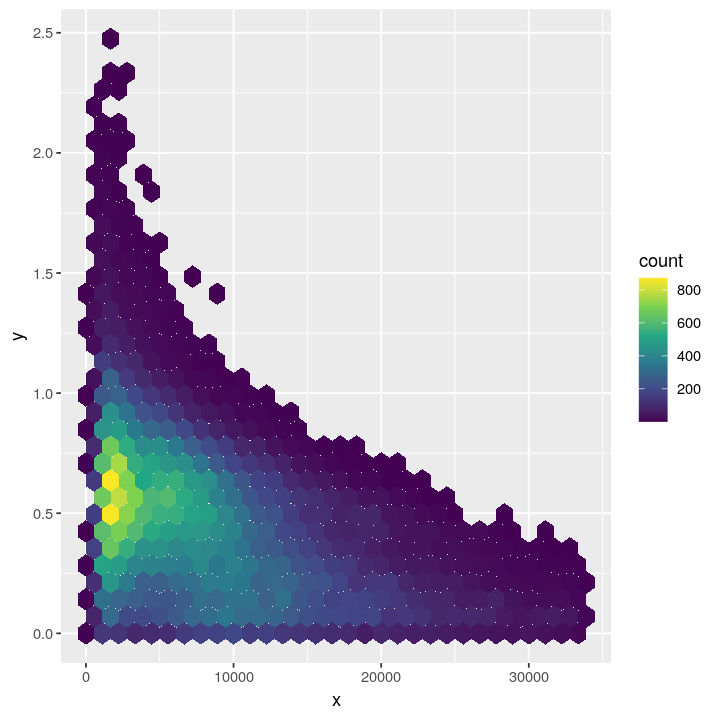

In [343]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data.frame(x=pmatRowSums, 
                  y=abs(dot_prod[,1])/pmatRowSums),
      aes(x=x, y=y)) +
scale_fill_continuous(type = "viridis") +
geom_hex()

In [345]:
quantile(dot_prod[,1]/pmatRowSums, 0.95)

95% 
0.07621717

In [319]:
plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = dot_prod[,i]/pmatRowSums
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    plots[[i]] = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(sim_score, 0.1),quantile(sim_score, 0.95)), oob = squish) +
    ggtitle(sprintf("%s (difference from Co-culture)", colnames(data.use)[i])) + 
    theme(plot.title = element_text(hjust = 0.5)) 
}

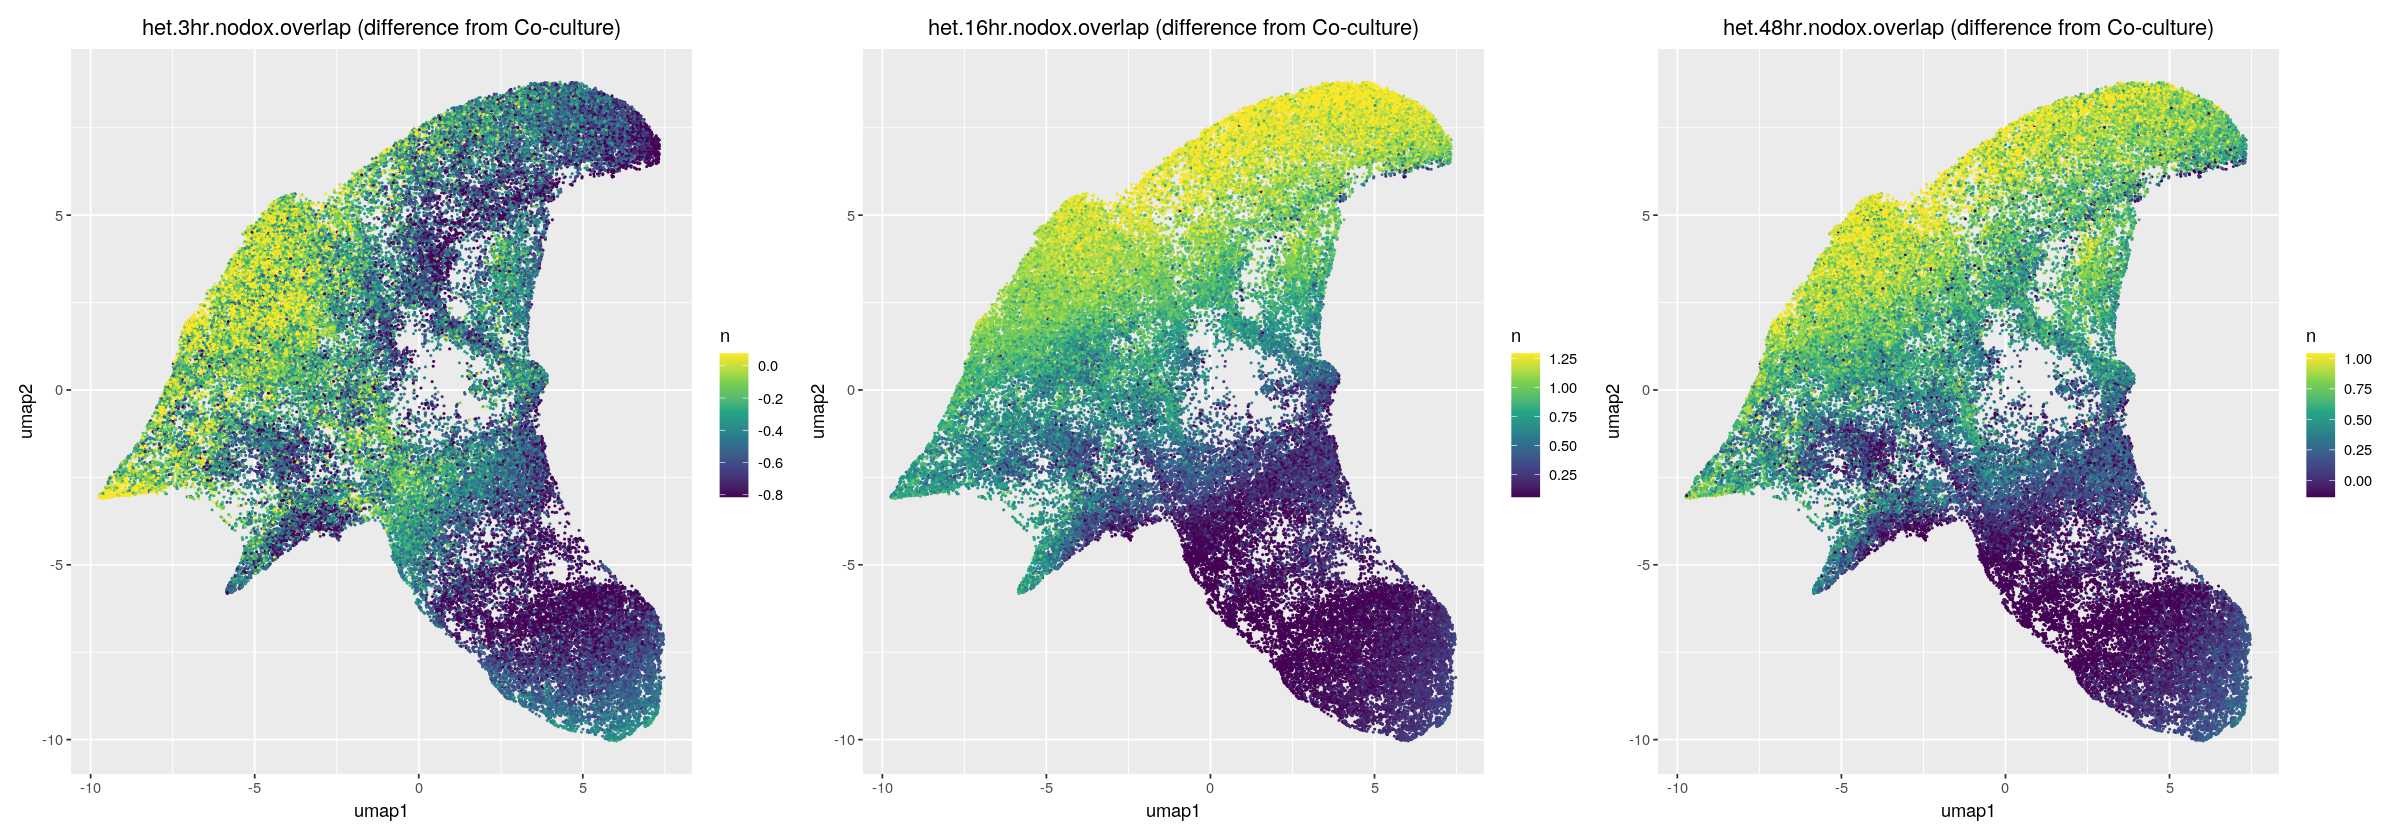

In [320]:
options(repr.plot.width = 20, repr.plot.height = 7)
wrap_plots(plots)

## Hard Single-cell similarity
Look at fraction of reads in peaks that are present in 3hr but not in CC/MRC5.

In [ ]:
het_peaks <- read.table("./data/20200518_n76052/het.peaks.overlap.no_iPSC.merge.500.tsv", header=T)
rownames(het_peaks)=paste(het_peaks$chrom,het_peaks$start,het_peaks$end,sep='_')
het_peaks$chrom = NULL
het_peaks$start = NULL
het_peaks$end = NULL
head(het_peaks)
dim(het_peaks)

In [ ]:
max(het_peaks)

In [25]:
# binarize, since they are peaks (construction of peak sets doesn't necessarily do that)
het_peaks[het_peaks>0] = 1
colSums(het_peaks)

het.MRC5.nodox   het.CC.nodox  het.3hr.nodox het.16hr.nodox het.48hr.nodox 
        143959         106671         117767         117806         118541 
   het.MRC5.dn      het.CC.dn     het.3hr.dn    het.16hr.dn    het.48hr.dn 
        115702          80591          95004          79634          68430

In [26]:
sum(rowSums(het_peaks)>0)

[1] 196971

In [23]:
# Peaks open in samples not open in MRC5 and CC
het_nodox_CC_MRC5_delta_peaks = het_peaks[, c("het.3hr.nodox","het.16hr.nodox","het.48hr.nodox")]
het_nodox_CC_MRC5_delta_peaks = het_nodox_CC_MRC5_delta_peaks[rowSums(het_peaks[, c("het.MRC5.nodox","het.CC.nodox")])==0, ]
dim(het_nodox_CC_MRC5_delta_peaks)

het_dn_CC_MRC5_delta_peaks = het_peaks[, c("het.3hr.dn","het.16hr.dn","het.48hr.dn")]
het_dn_CC_MRC5_delta_peaks = het_dn_CC_MRC5_delta_peaks[rowSums(het_peaks[, c("het.MRC5.dn","het.CC.dn")])==0, ]
dim(het_dn_CC_MRC5_delta_peaks)

[1] 257924      3

[1] 282975      3

In [6]:
colSums(het_nodox_CC_MRC5_delta_peaks)
colSums(het_dn_CC_MRC5_delta_peaks)

het.3hr.nodox het.16hr.nodox het.48hr.nodox 
          9781          15684          17101

het.3hr.dn het.16hr.dn het.48hr.dn 
       9465       15486       12736

In [9]:
sum(rowSums(het_nodox_CC_MRC5_delta_peaks)>0)
sum(rowSums(het_dn_CC_MRC5_delta_peaks)>0)

[1] 29696

[1] 27849

In [162]:
data.use = het_nodox_CC_MRC5_delta_peaks

In [163]:
frac_read_in_peak = list()

for (i in seq(dim(data.use)[2])) {
    frac_read_in_peak[[i]] = 100*Matrix::rowSums(pmat[,rownames(regions) %in% rownames(data.use)[data.use[,i]>0]])/pmatRowSums
}

In [164]:
cor(frac_read_in_peak[[1]], pmatRowSums,method='spearman')

[1] 0.1705876

In [165]:
hard_sim_plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = frac_read_in_peak[[i]]
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    hard_sim_plots[[i]] = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(sim_score, 0.1),
                                  quantile(sim_score, 0.95)), 
                          oob = squish,
                         name="FRiP") +
    ggtitle(sprintf("%s (%d Peaks, not in MRC5/CC)", colnames(data.use)[i], sum(data.use[,i]>0))) + 
    theme(plot.title = element_text(hjust = 0.5)) 
}

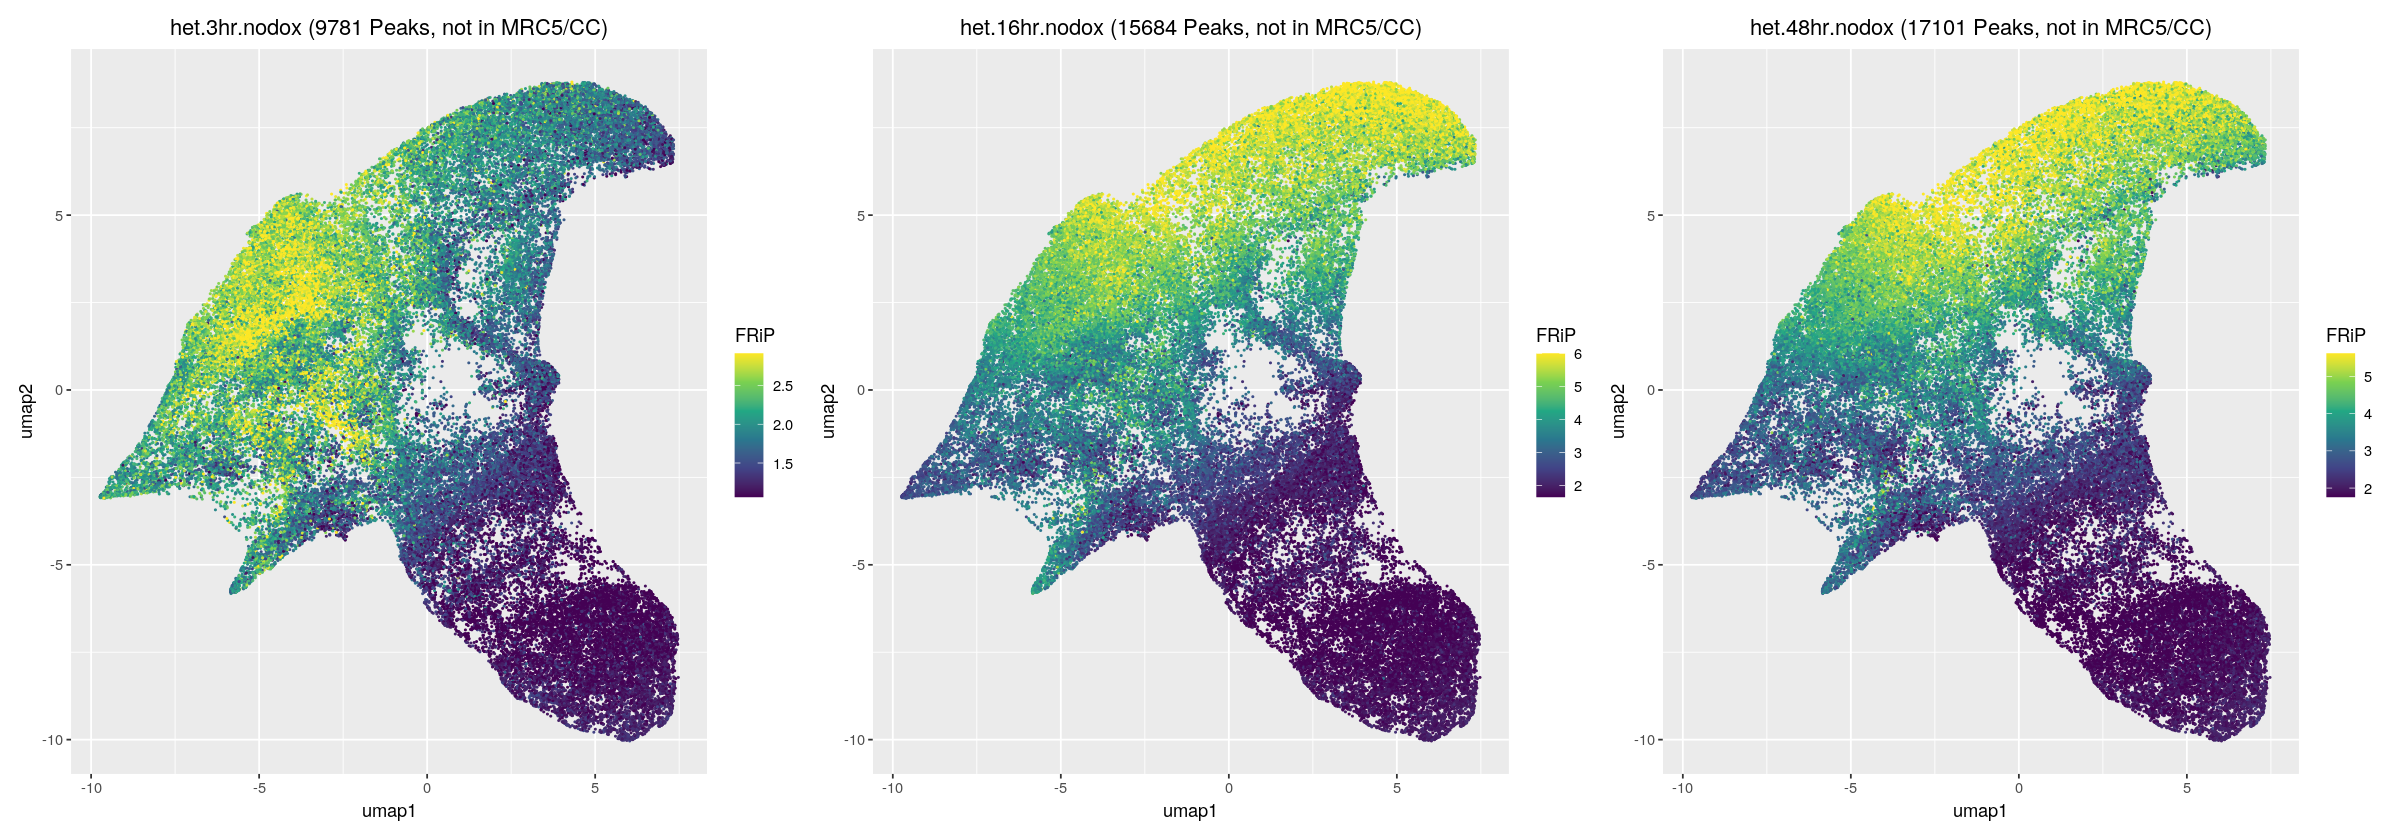

In [166]:
options(repr.plot.width = 20, repr.plot.height = 7*ceiling(dim(data.use)[2]/3))
wrap_plots(hard_sim_plots, ncol=3)

In [63]:
tmp =  rownames(data.use)[(data.use[,1]>0)]
tmp = tmp[sample(length(tmp))]
gsub("_", " ", head(tmp))

[1] "chr9 77018326 77019106"   "chr3 172278928 172279535"
[3] "chr4 110904520 110906175" "chr18 8661668 8662724"   
[5] "chr12 2921342 2922944"    "chr7 151416165 151417537"

In [64]:
conn = file("tmp")
write.table(gsub("_", "\t", tmp), file="tmp", sep="\t", quote=F, row.names=F, col.names=F)

### At Cluster Level

In [46]:
# load fine clusters from file
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/fine_clusters.tsv", 
            header = T)
all(fine_clusters$sample_barcode==rownames(metaData))

clusters = fine_clusters$clusters
head(fine_clusters)

[1] TRUE

sample_barcode      clusters
1 D0_AAACAACGACGATTAC 26      
2 D0_AAACAACGAGCGCACT 42      
3 D0_AAACACGCTACGCCAC 42      
4 D0_AAACACGCTAGTACGG 11      
5 D0_AAACACGCTCCTCAAA 13      
6 D0_AAACACGCTCGAGTGA 10

In [47]:
library(RColorBrewer)

qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

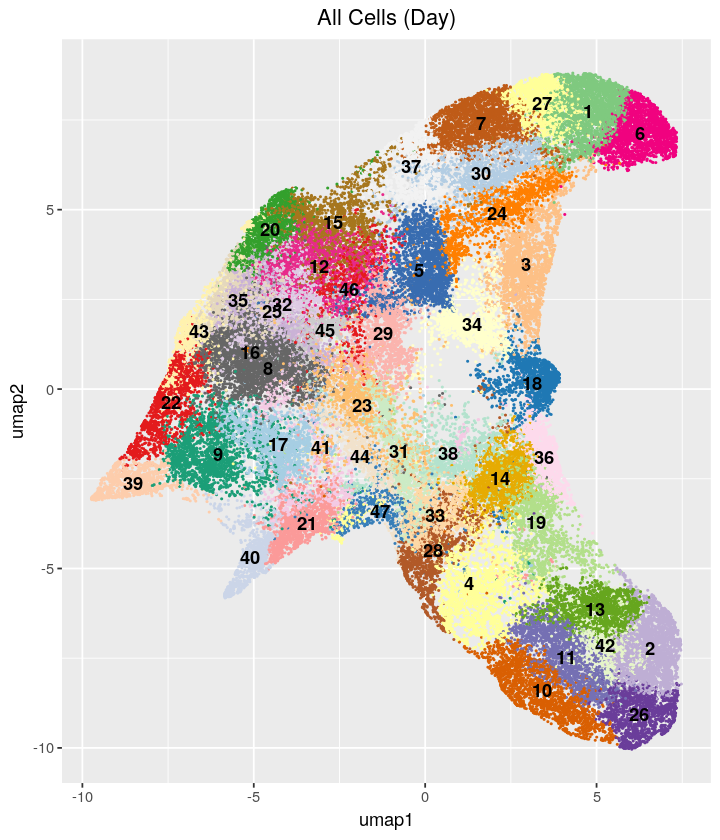

In [48]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(clusters), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [49]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(pmat)))

In [31]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) =  rownames(regions)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1_10355_10867  7        18        10        1          7         4       
chr1_41995_42521  1        12         6        6          6         3       
chr1_46067_46593  5         4        15        5         15         4       
chr1_48475_48975  0         2         3        1          4         1       
chr1_51286_52235 30         6        46        3          6        35       
chr1_58648_59148  0         2         4        2          0         2       
                 cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_38
chr1_10355_10867  3        10        10        15         ⋯ 10        
chr1_41995_42521  0         8        23         6         ⋯  5        
chr1_46067_46593  8        17        10         5         ⋯  6        
chr1_48475_48975  2        31        10         2         ⋯  3        
chr1_51286_52235 43        12         1         6         ⋯  3        
chr1_58648_59148  1        23        10         1         ⋯  4        
                 cluster_39 cluster_40 cluster_41 cluster_42 cluster_43
chr1_10355_10867 4          4          5          2           3        
chr1_41995_42521 4          3          6          3           1        
chr1_46067_46593 1          3          6          1           3        
chr1_48475_48975 5          1          5          2          12        
chr1_51286_52235 1          1          1          1           5        
chr1_58648_59148 3          2          3          1           9        
                 cluster_44 cluster_45 cluster_46 cluster_47
chr1_10355_10867 2           8         3          5         
chr1_41995_42521 9           7         4          1         
chr1_46067_46593 9          11         6          2         
chr1_48475_48975 2           2         2          2         
chr1_51286_52235 2          11         2          0         
chr1_58648_59148 0           4         2          1

[1] 409052     47

In [32]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

In [61]:
hard_sim_plots = list()

for (i in seq(1,dim(data.use)[2])) {
    sim_score = log2(colSums(norm_cts[rownames(regions) %in% rownames(data.use)[data.use[,i]>0], ]))[clusters]
    df = data.frame(metaData, n=sim_score)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    hard_sim_plots[[i]] = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(# limit=c(min(sim_score),
                          #       max(sim_score)), 
                          # oob = squish,
                         name="Log2\nNormalized Counts") +
    ggtitle(sprintf("%s (%d Peaks, not in MRC5/CC)", colnames(data.use)[i], sum(data.use[,i]>0))) + 
    theme(plot.title = element_text(hjust = 0.5)) 
}

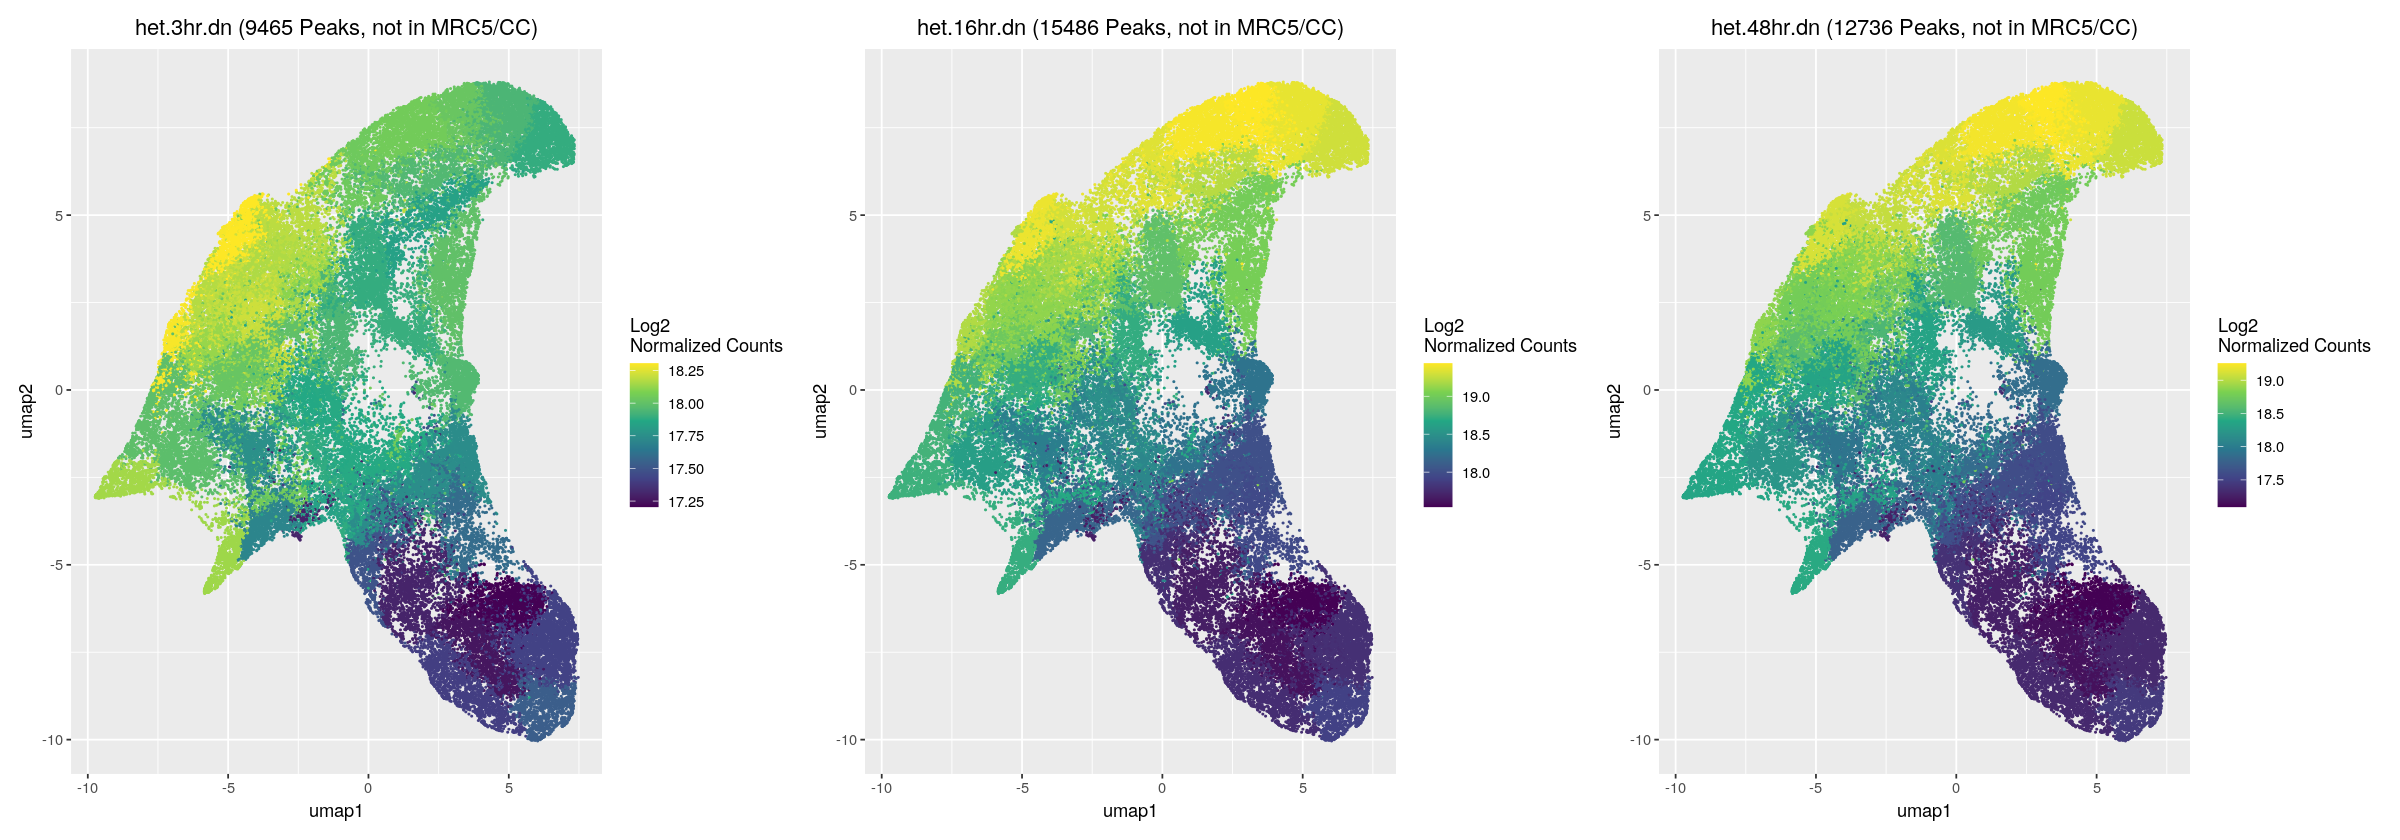

In [62]:
options(repr.plot.width = 20, repr.plot.height = 7)
wrap_plots(hard_sim_plots, ncol=3)